In [2]:
import treecorr as tc
import healpy as hp
import numpy as np

In [3]:
Nside = 1024
mask = hp.read_map('/uufs/astro.utah.edu/common/home/u6060319/quasar-CMBlening/data/Planck/mask/mask.fits')
dat = hp.read_alm('/uufs/astro.utah.edu/common/home/u6060319/quasar-CMBlening/data/Planck/MV/dat_klm.fits')
image = hp.sphtfunc.alm2map(dat, nside=Nside, pol=False)
mask = hp.ud_grade(mask, Nside)
image_masked = hp.ma(image)
image_masked.mask = np.logical_not(mask>0.5)
print('finish loading Planck kappa map.')

finish loading Planck kappa map.


In [4]:
theta, phi = hp.pix2ang(Nside, np.arange(len(image)))

In [5]:
l = phi[np.logical_not(image_masked.mask)]
b = np.pi/2 - theta[np.logical_not(image_masked.mask)]
kappa = image[np.logical_not(image_masked.mask)]

In [6]:
kappa_cat = tc.Catalog(ra=l, dec=b, ra_units='rad', dec_units='rad', k=kappa)

In [7]:
from astropy import coordinates as coo, units as u
cmass = np.load('/uufs/astro.utah.edu/common/home/u6060319/quasar-CMBlening/cmass_z_cut.npy')
Nquas = len(cmass)
c = coo.SkyCoord(ra=cmass['ra']*u.degree, dec=cmass['dec']*u.degree)

l = c.galactic.l.to(u.rad).value
b = c.galactic.b.to(u.rad).value
pos = hp.ang2vec(theta=np.pi/2-b, phi=l)
# position of each quasar
w_l = cmass['w']
# weighting of each quasar
z_l = cmass['z']
# redshift of each quasar
print('finish loading cmass catalogue')

finish loading cmass catalogue


In [8]:
cmass_cat = tc.Catalog(ra=l, dec=b, ra_units='rad', dec_units='rad', npatch=100, w=w_l)

In [24]:
cmass = np.load('/uufs/astro.utah.edu/common/home/u6060319/quasar-CMBlening/cmass_random.npy')
c = coo.SkyCoord(ra=cmass['ra']*u.degree, dec=cmass['dec']*u.degree)

l = c.galactic.l.to(u.rad).value
b = c.galactic.b.to(u.rad).value
print('finish loading random sample')
rand_point_cat = tc.Catalog(ra=l, dec=b, ra_units='rad', dec_units='rad', npatch=100)

finish loading random sample


In [56]:
# rand_point = np.loadtxt('../random_sample_theta_phi_z_5_000_000')
# rand_point_cat = tc.Catalog(ra=rand_point[:,1], dec=np.pi/2-rand_point[:,0], ra_units='rad', dec_units='rad', npatch=100)

In [12]:
from astropy.cosmology import Planck18 as cosmos
import astropy.coordinates as coo
h = cosmos.H0.to(u.km/u.s/u.Mpc).value / 100

In [13]:
z_l = 0.6
r_bins = np.geomspace(3, 100, 10)
d_A = cosmos.angular_diameter_distance(z_l).to(u.Mpc).value
r_bins/h/(1+z_l)/d_A

array([0.00195119, 0.00288077, 0.00425321, 0.00627951, 0.00927117,
       0.0136881 , 0.02020933, 0.02983738, 0.04405239, 0.06503965])

In [14]:
nk = tc.NKCorrelation(config={'metric': 'Arc', 'max_sep': 0.06503965, 'min_sep': 0.00195119, 'nbins':10, 'sep_units': 'rad'})
# nk = tc.NKCorrelation(config={'max_sep': 0.04352583, 'min_sep': 0.00130577, 'nbins':10, 'sep_units': 'rad'})

In [15]:
nk.process(cmass_cat, kappa_cat)

In [ ]:
cov = nk.estimate_cov('jackknife')
cov_ii = [cov[i,i] for i in range(cov.shape[0])]
for i in range(cov.shape[0]):
    for j in range(cov.shape[1]):
        cov[i,j] /= np.sqrt(cov_ii[i]*cov_ii[j])

import matplotlib.pyplot as plt
plt.imshow(cov, origin='lower')

[]

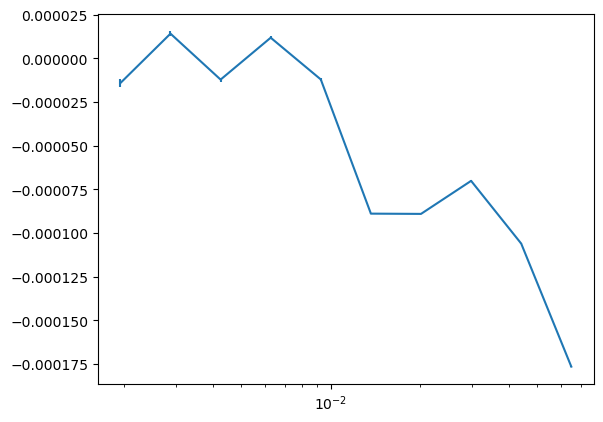

In [20]:
import matplotlib.pyplot as plt
r = np.geomspace(nk.min_sep, nk.max_sep, nk.nbins)
plt.errorbar(r, r*nk.xi, r*nk.varxi)
plt.semilogx()

The following patch numbers have no objects: {11, 13}
This may be a problem depending on your use case.


[]

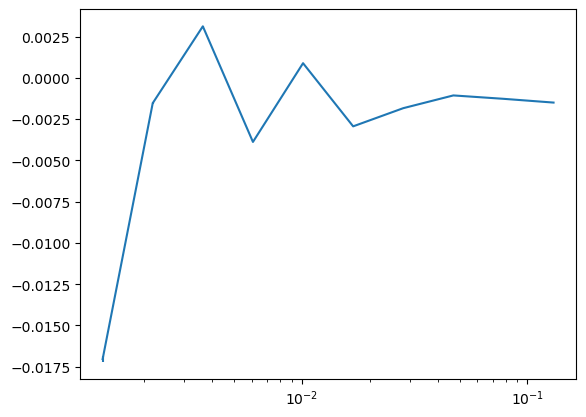

In [25]:
nk.process(rand_point_cat, kappa_cat)
r = np.geomspace(nk.min_sep, nk.max_sep, nk.nbins)
plt.errorbar(r, nk.xi, nk.varxi)
plt.semilogx()